In [6]:
# Risky Asset + Risk-free Asset 시계열모멘텀 전략 백테스트
# Monthly rebalancing 가정
# 모멘텀 측정기간(tau), 투자 시작일(stDateNum)을 바꿔가며 Back-test 가능

# 현재 디렉토리 확인
import os
os.getcwd()

# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [10]:
# ============================================================================
# Data 로딩 및 변수 정의
# ============================================================================
# 날짜 기준으로 오름차순 정렬된 Data 불러오기
data_excel = pd.ExcelFile('./Data/Mom_Data.xlsx') # read_excel과 차이= 엑셀 시트 여러개를 한번에 가져옴
data_df = data_excel.parse(sheet_name = 'data_m', header=1) # d / w(Fri) / m(EoM)
rawTime = data_df.iloc[:, 0].copy()  # Date
rawRisky = data_df.iloc[:, 1].copy() # Risky asset price (K200)
rawRf = data_df.iloc[:, 3].copy()    # Risk-free rate (CD1m, %)
numRaw = len(rawTime)

# 전체 기간에 대한 HPR (단위: %)
rawR1 = rawRisky.pct_change()*100 # (rawRisky / rawRisky.shift(1) - 1) * 100
rawR2 = rawRf.shift(1)/12 # CD1m의 정의를 고려하여 1칸 shift + 연율화 scaling

# 전체 기간에 대한 Risky asset의 mometum
Tau = np.array([3, 6, 9, 12]) 
numMom = len(Tau)
rawMom = pd.DataFrame(np.zeros([numRaw, numMom])) # Mom 지표로 simple return 사용
for i in range(numMom):
    tau = Tau[i]
    rawMom.iloc[:,i] = rawRisky.pct_change(tau)*100 # 데이터프레임에 tau 마다 column 채우기(수익률)
    
rawSignal = 1*(rawMom > 0) # 1: 모멘텀 있음 / 0: 모멘텀 없음

In [19]:
# ============================================================================
# Back Test 시작시점 기준으로 데이터 정리 (이 작업을 원하지 않으면 엑셀을 편집)
# ============================================================================
stDateNum = 19941228  # 19941228  # Back Test 시작일 (투자 시작일)
stDate = pd.to_datetime(str(stDateNum), format='%Y%m%d')
idx = np.argmin(np.abs(rawTime - stDate))  # Back Test 시작일에 해당하는 index

Time = rawTime[idx:].copy().reset_index(drop = True)  # 깊은 복사, index 초기화
R1 = rawR1[idx:].copy().reset_index(drop = True)
R2 = rawR2[idx:].copy().reset_index(drop = True)
Signal = rawSignal.iloc[idx:].copy().reset_index(drop = True)
numData = Time.shape[0]  # len(Data) or len(Data.index)

In [20]:
# ============================================================================
# 포트폴리오의 Value, DD 계산
# ============================================================================
# Weight
W1 = Signal  # Risky asset 투자비중
W2 = 1 - W1  # Risk - free asset 투자비중

# Portfolio Value
Rp = pd.DataFrame(np.zeros([numData, numMom])) # 수익률 (단위: %)
Vp = pd.DataFrame(np.zeros([numData, numMom])) # Value
Vp.iloc[0,:] = 100 # 투자원금 = 100
for t in range(1, numData) : 
    Rp.iloc[t,:] = W1.iloc[t-1,:]*R1[t] + W2.iloc[t-1,:]*R2[t]   # HPR
    Vp.iloc[t,:] = Vp.iloc[t-1,:]*(1 + Rp.iloc[t,:]/100)              # Value
    
# Portfolio DD
MAXp = Vp.cummax()
DDp = (Vp/MAXp - 1) * 100  # 단위: %

In [21]:
# ============================================================================
# 벤치마크의 Value, DD 계산
# ============================================================================
Risky = rawRisky[idx:].copy().reset_index(drop = True)

# BM Value (투자 시작일 기준으로 표준화)
Vb = (rawRisky[idx:] / rawRisky[idx]).reset_index(drop = True) * 100

# BM DD
MAXb = Vb.cummax()
DDb = (Vb / MAXb - 1) * 100  # 단위: %

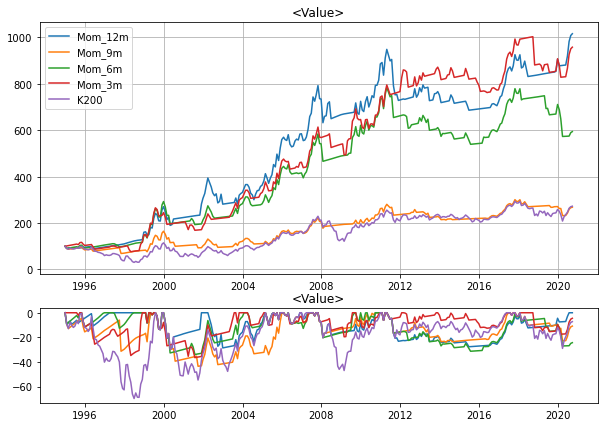

In [22]:
# ============================================================================
# 그래프 그리기
# ============================================================================

# Value와 MDD 그리기
fig = plt.figure(figsize = (10, 7))    # figsize = (가로길이, 세로길이)
gs = gridspec.GridSpec(nrows = 2,      # row 개수
                       ncols = 1,      # col 개수
                       height_ratios=[8, 3],
                       width_ratios=[5])    # subplot의 크기를 서로 다르게 설정

ax0 = plt.subplot(gs[0])
ax0.plot(Time, Vp.iloc[:,3], label = 'Mom_12m')
ax0.plot(Time, Vp.iloc[:,2], label = 'Mom_9m')
ax0.plot(Time, Vp.iloc[:,1], label = 'Mom_6m')
ax0.plot(Time, Vp.iloc[:,0], label = 'Mom_3m')
ax0.plot(Time, Vb, label = 'K200')
ax0.set_title('<Value>')
ax0.grid(True)
ax0.legend()

ax1 = plt.subplot(gs[1])
ax1.plot(Time, DDp.iloc[:,3], label = 'Mom_12m')
ax1.plot(Time, DDp.iloc[:,2], label = 'Mom_9m')
ax1.plot(Time, DDp.iloc[:,1], label = 'Mom_6m')
ax1.plot(Time, DDp.iloc[:,0], label = 'Mom_3m')
ax1.plot(Time, DDb, label = 'K200')
ax1.set_title('<Value>')
ax0.grid(True)
ax0.legend()

plt.show()